## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

## Tutorial 4: Gassusian Process Background (6-12 minutes)

Following the process level tutorial in introduction series, we can get a bit of taste that what Gaussian Process (GP) can do to infer sea-level change pattern and rate. In this temporal GP tutorial series, you will further explore the capability of GP in modelling sea-level change. In specific you will learn:

**&#10148; 1.** Squared distance function and covariance function 

**&#10148; 2.** RBF kernel and its hyperparameters

**&#10148; 3.** Conditional probability

**&#10148; 4.** Hyperparameter optimization

**Gaussian Process**

Gaussian Process (GP) is a nonparametric and Bayesian approach, which is a flexible and powerful method used to model and predict continuous variables based on observed data. In GP regression, he fundamental assumption is that the underlying function generating the data follows a Gaussian process, which is a collection of random variables where any finite subset has a joint Gaussian distribution. A Gaussian process is completely characterized by its mean function and covariance function, also known as the covariance function (aka kernel function). A kernel function, or a similarity function, is a key component used to model the covariance structure between different input points. It defines the relationship and similarity between input points based on their features. To better understand what is a kernel function, let's start with the basics. Note this GP tutorial series was written based on [this blog](https://www.niamhcahill.com/post/gp_tutorial/) by Niamh Cahill and [this tutorial](https://github.com/christopherpiecuch/bayesGavle/blob/main/20230705_gia_v7.pdf) by Chris Piecuch. 

### 1. Squared distance function and covariance function

The covariance function takes two input points, typically denoted as x and x', and computes a measure of similarity or correlation between them. It provides a measure of how similar the outputs at those points are expected to be. For temporal sea-level modelling, we are measuring two data points with time t and t', and we expect two data points with small time difference (say 1 hour aparts) should more similar output variable $y,y'$ (say outdoor temperature) than two data points that are far away from each other (say 10 hours apart). 

Let's take real daily outdoor temperature at New Brunswick as an example, to make it mimic the behaviour of paleo sea-level, we will add a random Gaussian noise to it with 0 mean and 2 degree F sigma.


In [ ]:
# Installs the necessary pyro-ppl package as well as mounts the tutorial directory into google colab from drive so users can access the data directory
# Only run this cell if you are using google colab
# If you are not using google colab, please ignore this cell
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Install pyro-ppl
    %pip install pyro-ppl cartopy

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Change directory
    %cd /content/drive/MyDrive/PaleoSTeHM/Tutorials/2.Temporal_GP
else:
    # Continue to the next cell
    pass

In [1]:
#load modules
import os
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import sys
sys.path.append('../..')
import PSTHM 
import time
import seaborn as sns
from scipy import interpolate
smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

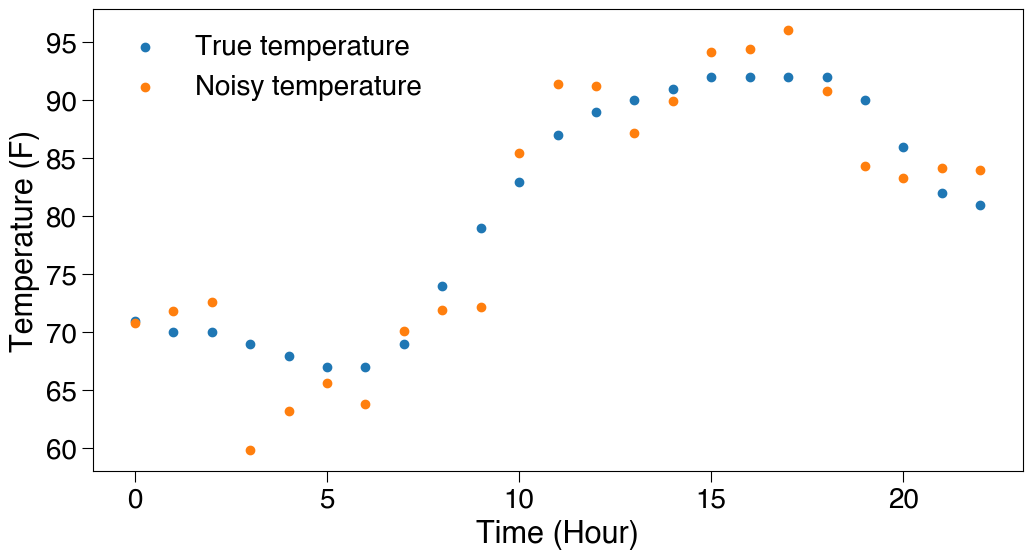

In [9]:
np.random.seed(10)
NB_t = pd.read_csv('Data/tem_data_NB.csv',header=None)
t,tem = NB_t.iloc[:,0].values,NB_t.iloc[:,1].values
noise_tem = tem+np.random.normal(0,4,len(tem))

plt.scatter(t,tem,label='True temperature')

plt.scatter(t,noise_tem,label='Noisy temperature')
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)')
plt.legend();

We can clearly see that any two data points that are one hour apart from each other should have more similar temperature than those are 10 hours apart from each other. To quantify this, let's first generate a matrix that quantify the suqared time difference between each of two data points:
$$
D = \begin{pmatrix}
  (t_{1} -t_{1})^2      & (t_{1} -t_{2})^2     & \cdots  & (t_{1} -t_{n})^2  \\
  (t_{2} -t_{1})^2       &   (t_{2} -t_{2})^2     & \cdots  & (t_{2} -t_{n})^2 \\
  \vdots  & \vdots   & \ddots  & \vdots \\
  (t_{n} -t_{1})^2       & (t_{n} -t_{2})^2    & \cdots  & (t_{n} -t_{n})^2 \\
\end{pmatrix}
$$
where $n$ indicates the number of data points we have. Let's do this for our dataset.

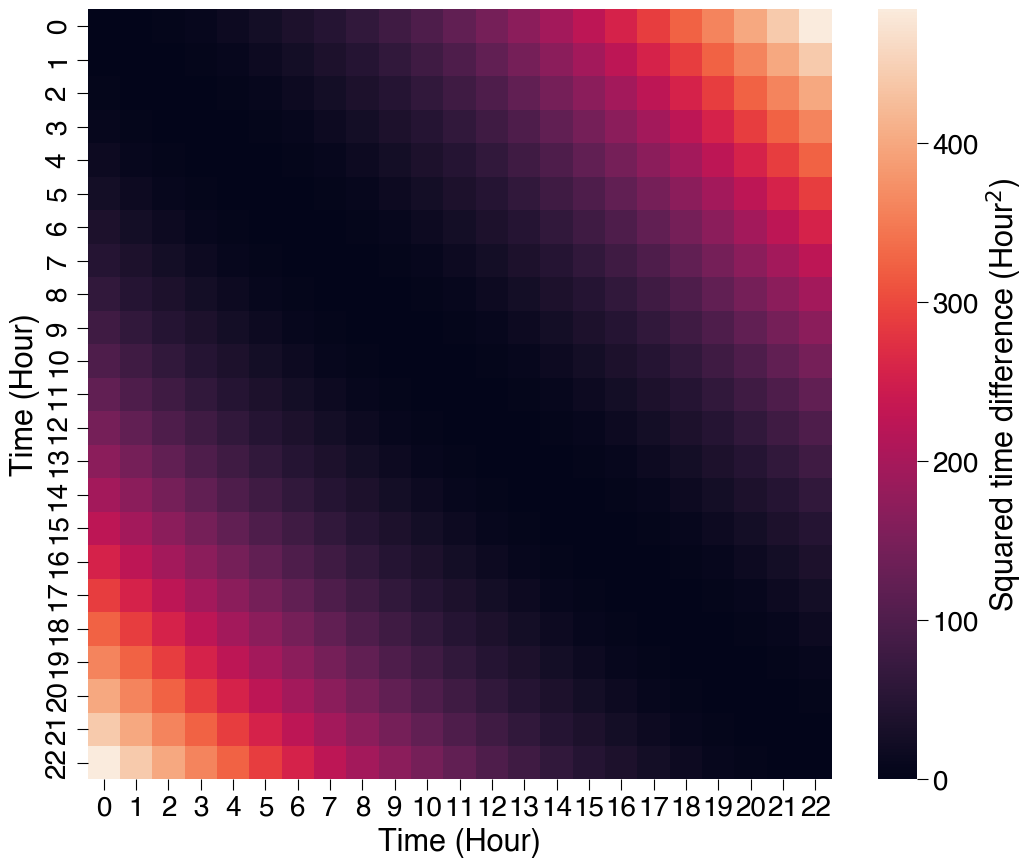

In [10]:
sqaured_diff_mat = (t[:,None]-t[None,:])**2
plt.figure(figsize=(12,10))
sns.heatmap(sqaured_diff_mat,cbar_kws={'label': 'Squared time difference (Hour$^2$)'})
plt.xlabel('Time (Hour)')
plt.ylabel('Time (Hour)');

### 2. RBF kernel and its hyperparameters

Now we know the squared time difference between each data point, and now, we can include a kernel to measure "how similar the temperature between two data points given their squared time difference". For GP regression, a very popular choice is the squared exponential kernel (i.e., [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel); RBF):
$$
k_{RBF}(t,t') = \sigma^2\exp\left(-0.5 \times \frac{|t-t'|^2}{l^2}\right)
$$
where $|t-t'|^2$ is equivalent to our sqaured time difference function $D$ above; $\sigma ^2$ and $l$ are variance and lengthscale hyperparameters that control the overall amplitude and smoothness of the kernel function. To give you some ideas about how they control the covariance, let's try three different combinations:


| Model | $l$  | $\sigma ^2$ |
|  :---:|  :---:  |    :---: |
| 1  | 3      |    10|
|  2  | 3      |    30 |
|  3  | 9      |    10 |


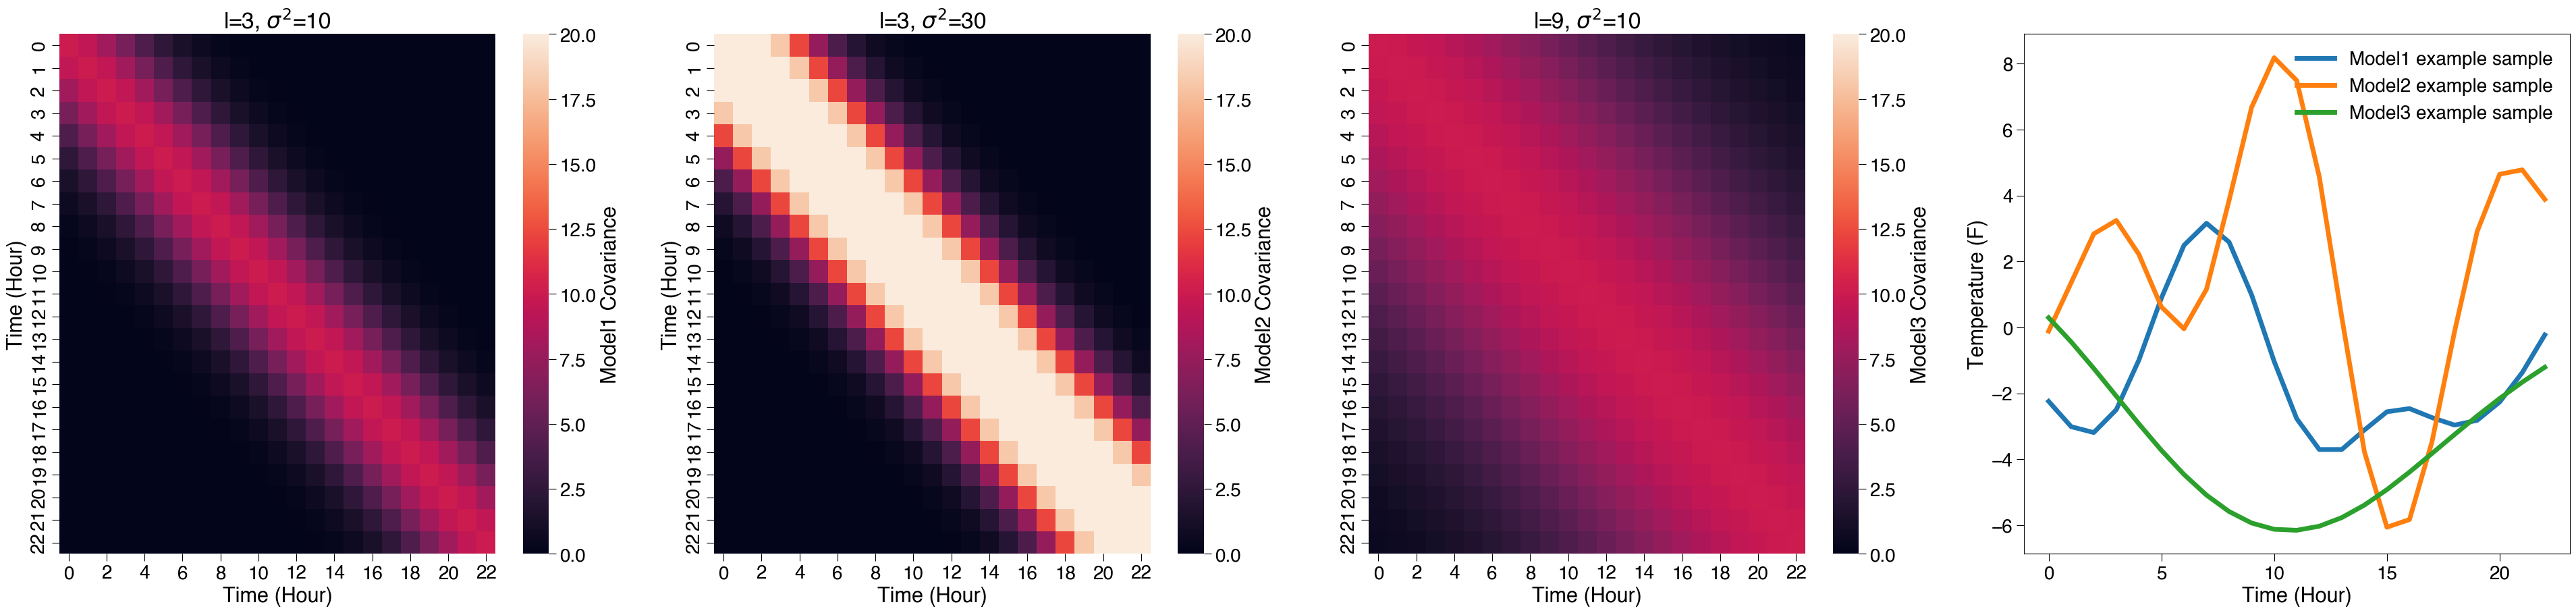

In [18]:
model1 = 10*np.exp(-0.5*sqaured_diff_mat/3**2)
model2 = 30*np.exp(-0.5*sqaured_diff_mat/3**2)
model3 = 10*np.exp(-0.5*sqaured_diff_mat/9**2)

plt.figure(figsize=(48,10))

plt.subplot(1,4,1)
sns.heatmap(model1, vmax=20,vmin=0,cbar_kws={'label': 'Model1 Covariance'})
plt.xlabel('Time (Hour)')
plt.ylabel('Time (Hour)')
plt.title('l=3, $\sigma^2$=10')

plt.subplot(1,4,2)
sns.heatmap(model2, vmax=20,vmin=0,cbar_kws={'label': 'Model2 Covariance'})
plt.title('l=3, $\sigma^2$=30')
plt.xlabel('Time (Hour)')
plt.ylabel('Time (Hour)')

plt.subplot(1,4,3)
sns.heatmap(model3, vmax=20,vmin=0,cbar_kws={'label': 'Model3 Covariance'})
plt.xlabel('Time (Hour)')
plt.title('l=9, $\sigma^2$=10');

#draw sample from a multivariate normal distribution using covariance matrix above
sample1 = np.random.multivariate_normal(np.zeros(len(model1)), cov=model1)
sample2 = np.random.multivariate_normal(np.zeros(len(model2)), cov=model2)
sample3 = np.random.multivariate_normal(np.zeros(len(model3)), cov=model3)
plt.subplot(1,4,4)
plt.plot(t,sample1,label='Model1 example sample',lw=5)
plt.plot(t,sample2,label='Model2 example sample',lw=5)
plt.plot(t,sample3,label='Model3 example sample',lw=5)
plt.legend()
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');

The first three subplots show the covariance matrix given two hyperparameters, and the last subplot shows the example sample draws from a multivariate Gaussian distribution using the three covariance matricies on the left with 0 mean. The example sample draws here can be seen as blind draws without observing any data, which can be expressed as:
$$
p(f| \sigma, l) \sim GP(0,k_{RBF}(t,t'))
$$

where '|' means `given`. A 0 mean implies that, on average, the predicted values are expected to be centered around zero. This assumption is often used when there is no prior knowledge or specific information about the mean behavior of the underlying function. However, it's important to note that using a zero mean function does not imply that the predicted values will be exactly zero. The GP regression model captures the deviations from the mean function using the covariance defined by the kernel function. Thus, the mean function represents the average behavior, while the covariance captures the variability and patterns in the data.

By comparing model 1 and 2, we can see that $\sigma$ mainly controls the amplitude of covariance matrix, which in turn controls the average distance of function away from its mean. The impact of $l$ can be found between model 1 and 3, where we can see that the covariance between two data point decrease slower in model 3, meaning one data point will have more impact on another data point further away from it. This can be seen in the last subplot that the sample from model 3 is not as wiggle as model 1 and 2. 

For this tutorial, we will use a framework called [pyro](pyro.ai), a universal probabilistic programming language written in Python and supported by PyTorch on the backend. And because we use PyTorch as the backend, we need to make sure every data should be presented in [torch.tensor](https://pytorch.org/docs/stable/tensors.html).You can easily do the same thing in pyro by the following code:

In [41]:
pyro.clear_param_store()
#build covariance matrix
RBF1 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(10))
RBF2 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(30))
RBF3 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(9),variance=torch.tensor(10))
#calculate covariance matrix for time t
t = torch.tensor(t)
noise_tem = torch.tensor(noise_tem)
tem = torch.tensor(tem)

model1 = RBF1(t)
model2 = RBF2(t)
model3 = RBF3(t)

### 3. Conditional probability

Now, we can start to calculate conditional probability, given we have some observational data. This time, we can express the inference as:
$$
p(f| \sigma, l, y) \sim GP(0,k_{RBF}(t,t'))
$$
Because the conditional probability of a multivariate Gaussian distribution is another multivariate Gaussian distribution, we are interested to infer the mean (or expected value, $E$) and covariance matrix $Cov_{pred}$ of the resulting conditional probablity. But one thing before that is, with GP, we are interested to infer temperature values for a series of unknown time $t^{*}$ instead of known time $t$, so we should bring in a new notation:
$$
K = k(t,t')
$$
so $K_{RBF}$ is equivalent to what we have done above. Hence, if we have $n$ data point, $K$ should have a shape of $(n \times n)$. And for new time point $t_*$, we can write:
$$
K_* = k(t,t_*)
$$
indicating we are first calculating the sqaured distance between each new time point with known data point $t$. Hence, if we want to calculate 100 new time points (denotes as $n_{2}$), this distance matrix should have a shape of $(n \times n_{2} )$. Then this new covariance matrix ($K_*$) can be calculated based on this new squared distance matrix. And to calculate conditional probablility, we also need to calculate a covariance matrix between any two unknown time point:
$$
K_{**} = k(t_*,t_*)
$$
In this case, $K_{**}$ should have a shape of $(n_{2} \times n_{2})$. Once we calculate these, we can start to infer the conditional probablity of $y^{*}$ in unknown time $t^{*}$, which can be expressed as:
$$
E(y_{*}| \sigma, l, y) = K_{*}^{T}K^{-1}y\\
Cov(y_{*}| \sigma, l, y) = K_{**} - K_{*}^{T}K^{-1}K_{*}
$$
In many paleo-environmental applications, the observation $y$ can be noisy (recall data level tutorial):
$$
y_{i} = f(t_{i},x_{i}) + \epsilon_{i}
$$
In GP regression framework, this can be nicely embedded in kernel function by replacing $K^{-1}$ in the equation above with:
$$
\hat{K}^{-1} = (K+\Sigma_{\epsilon})^{-1}
$$
where $I$ is an identity matrix, and $\Sigma_{\epsilon}$ indicates covariance function of observational uncertainty. If we assume each observational data is independent, this can be re-written as:

$$
\hat{K}^{-1} = (K+\sigma_{\epsilon}I)^{-1}

$$

where $I$ is the identity matrix. Here we do not include the theoretical provement of these equations, if you are interested to know more about it, you can check section 2 of [this book](https://gaussianprocess.org/gpml/chapters/RW.pdf) by Rasmussen and Williams, 2006. 

It is very easy to perform these in pyro, with the following procedures:

* Clear parameter store: it is very important to clear all parameter store for every pyro model
* Build a RBF kernel: we should define 2 hyperparameters
* Build a GP model: we should set input dimension (which is 1 here), input varaible (time), output variable (temperature) and observational noise (all data points have one-sigma noise of 2 here)
* Run GP model: this indicates we are calculating conditional probability given the observations and hyperparameters

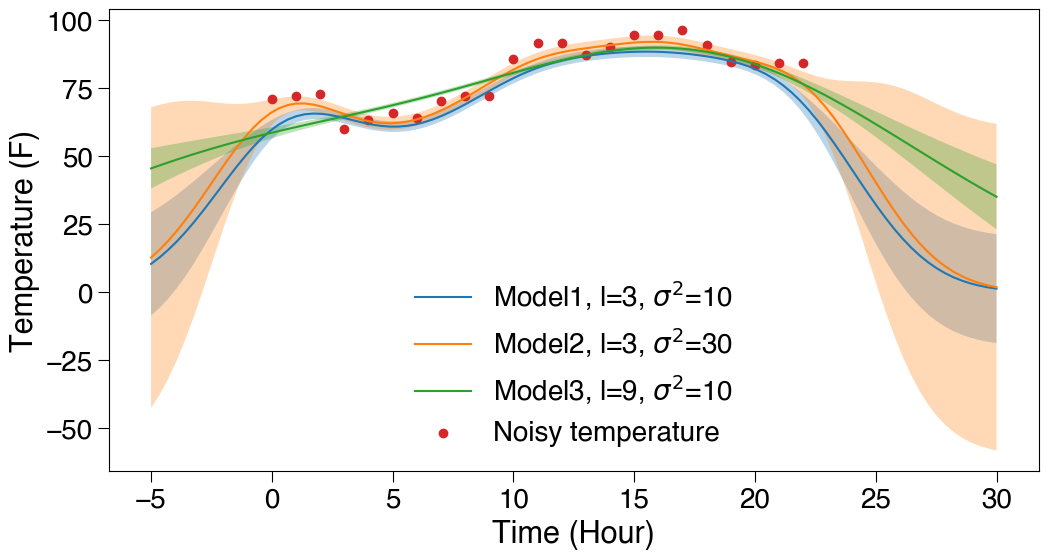

In [55]:
#make sure you clear all the parameter store before you define a new model
pyro.clear_param_store()
#define GP regression models
RBF1 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(10))
#define GP regression models
gpr1 = PSTHM.model.GPRegression_V(t, noise_tem, RBF1,noise=torch.ones(len(t))*2**2) #noise is the variance of the uncertainty 
#infer conditional probability distribution for unknown time
time_new = torch.linspace(-5,30,100).double()
mean1, sd1 = gpr1(time_new)

pyro.clear_param_store()
RBF2 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(30))
gpr2 = PSTHM.model.GPRegression_V(t, noise_tem, RBF2,noise=torch.ones(len(t))*2**2)
mean2, sd2 = gpr2(time_new)

pyro.clear_param_store()
RBF3 = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(9),variance=torch.tensor(10))
gpr3 = PSTHM.model.GPRegression_V(t, noise_tem, RBF3,noise=torch.ones(len(t))*2**2)
mean3, sd3 = gpr3(time_new)

#-----------------plot-----------------
#in order to plot it with matplotlib, we need to convert torch tensor to numpy array    
plt.figure(figsize=(12,6))
plt.plot(time_new.detach().numpy(),mean1.detach().numpy(),label='Model1, l=3, $\sigma^2$=10')
plt.fill_between(time_new.detach().numpy(),(mean1-2*sd1).detach().numpy(),(mean1+2*sd1).detach().numpy(),alpha=0.3)
plt.plot(time_new.detach().numpy(),mean2.detach().numpy(),label='Model2, l=3, $\sigma^2$=30')
plt.fill_between(time_new.detach().numpy(),(mean2-2*sd2).detach().numpy(),(mean2+2*sd2).detach().numpy(),alpha=0.3)
plt.plot(time_new.detach().numpy(),mean3.detach().numpy(),label='Model3, l=9, $\sigma^2$=10')
plt.fill_between(time_new.detach().numpy(),(mean3-2*sd3).detach().numpy(),(mean3+2*sd3).detach().numpy(),alpha=0.3)
plt.scatter(t,noise_tem.detach().numpy(),label='Noisy temperature')


plt.legend(loc=8)
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');


You should be able to see the following effects from different hyperparameters:

1. With larger $l$, like model 3, the output model will be less wiggle as models 1 and 2 with smaller $l$. Compared to model 3, it takes model 1 and 2 less distance to drop to the mean value of 0 after the last observation at 22.
1. The impact of $\sigma ^2$ can be found by comparing model 1 and 2, you can find out that model 2 shows much larger uncertainty range relative to model 1 in unknown time located away from the observations.
1. Mean function, as we use a 0 mean here, which means all model will present a 0 prediction for times far away from observations.

### 4. Hyperparameter optimization

Once you understand the impact of different hyperparameter combinations, we can start to find the hyperparameters that best fit the observational data, as we did in analysis choice tutorial. Also, we want the model to infer the variance of observational noise, which we set as 4 above. Here we use empirical Bayes method to optimize hyperparameters with maximum likelihood estimate.

  0%|          | 0/1500 [00:00<?, ?it/s]

Execution time: 2.091 s


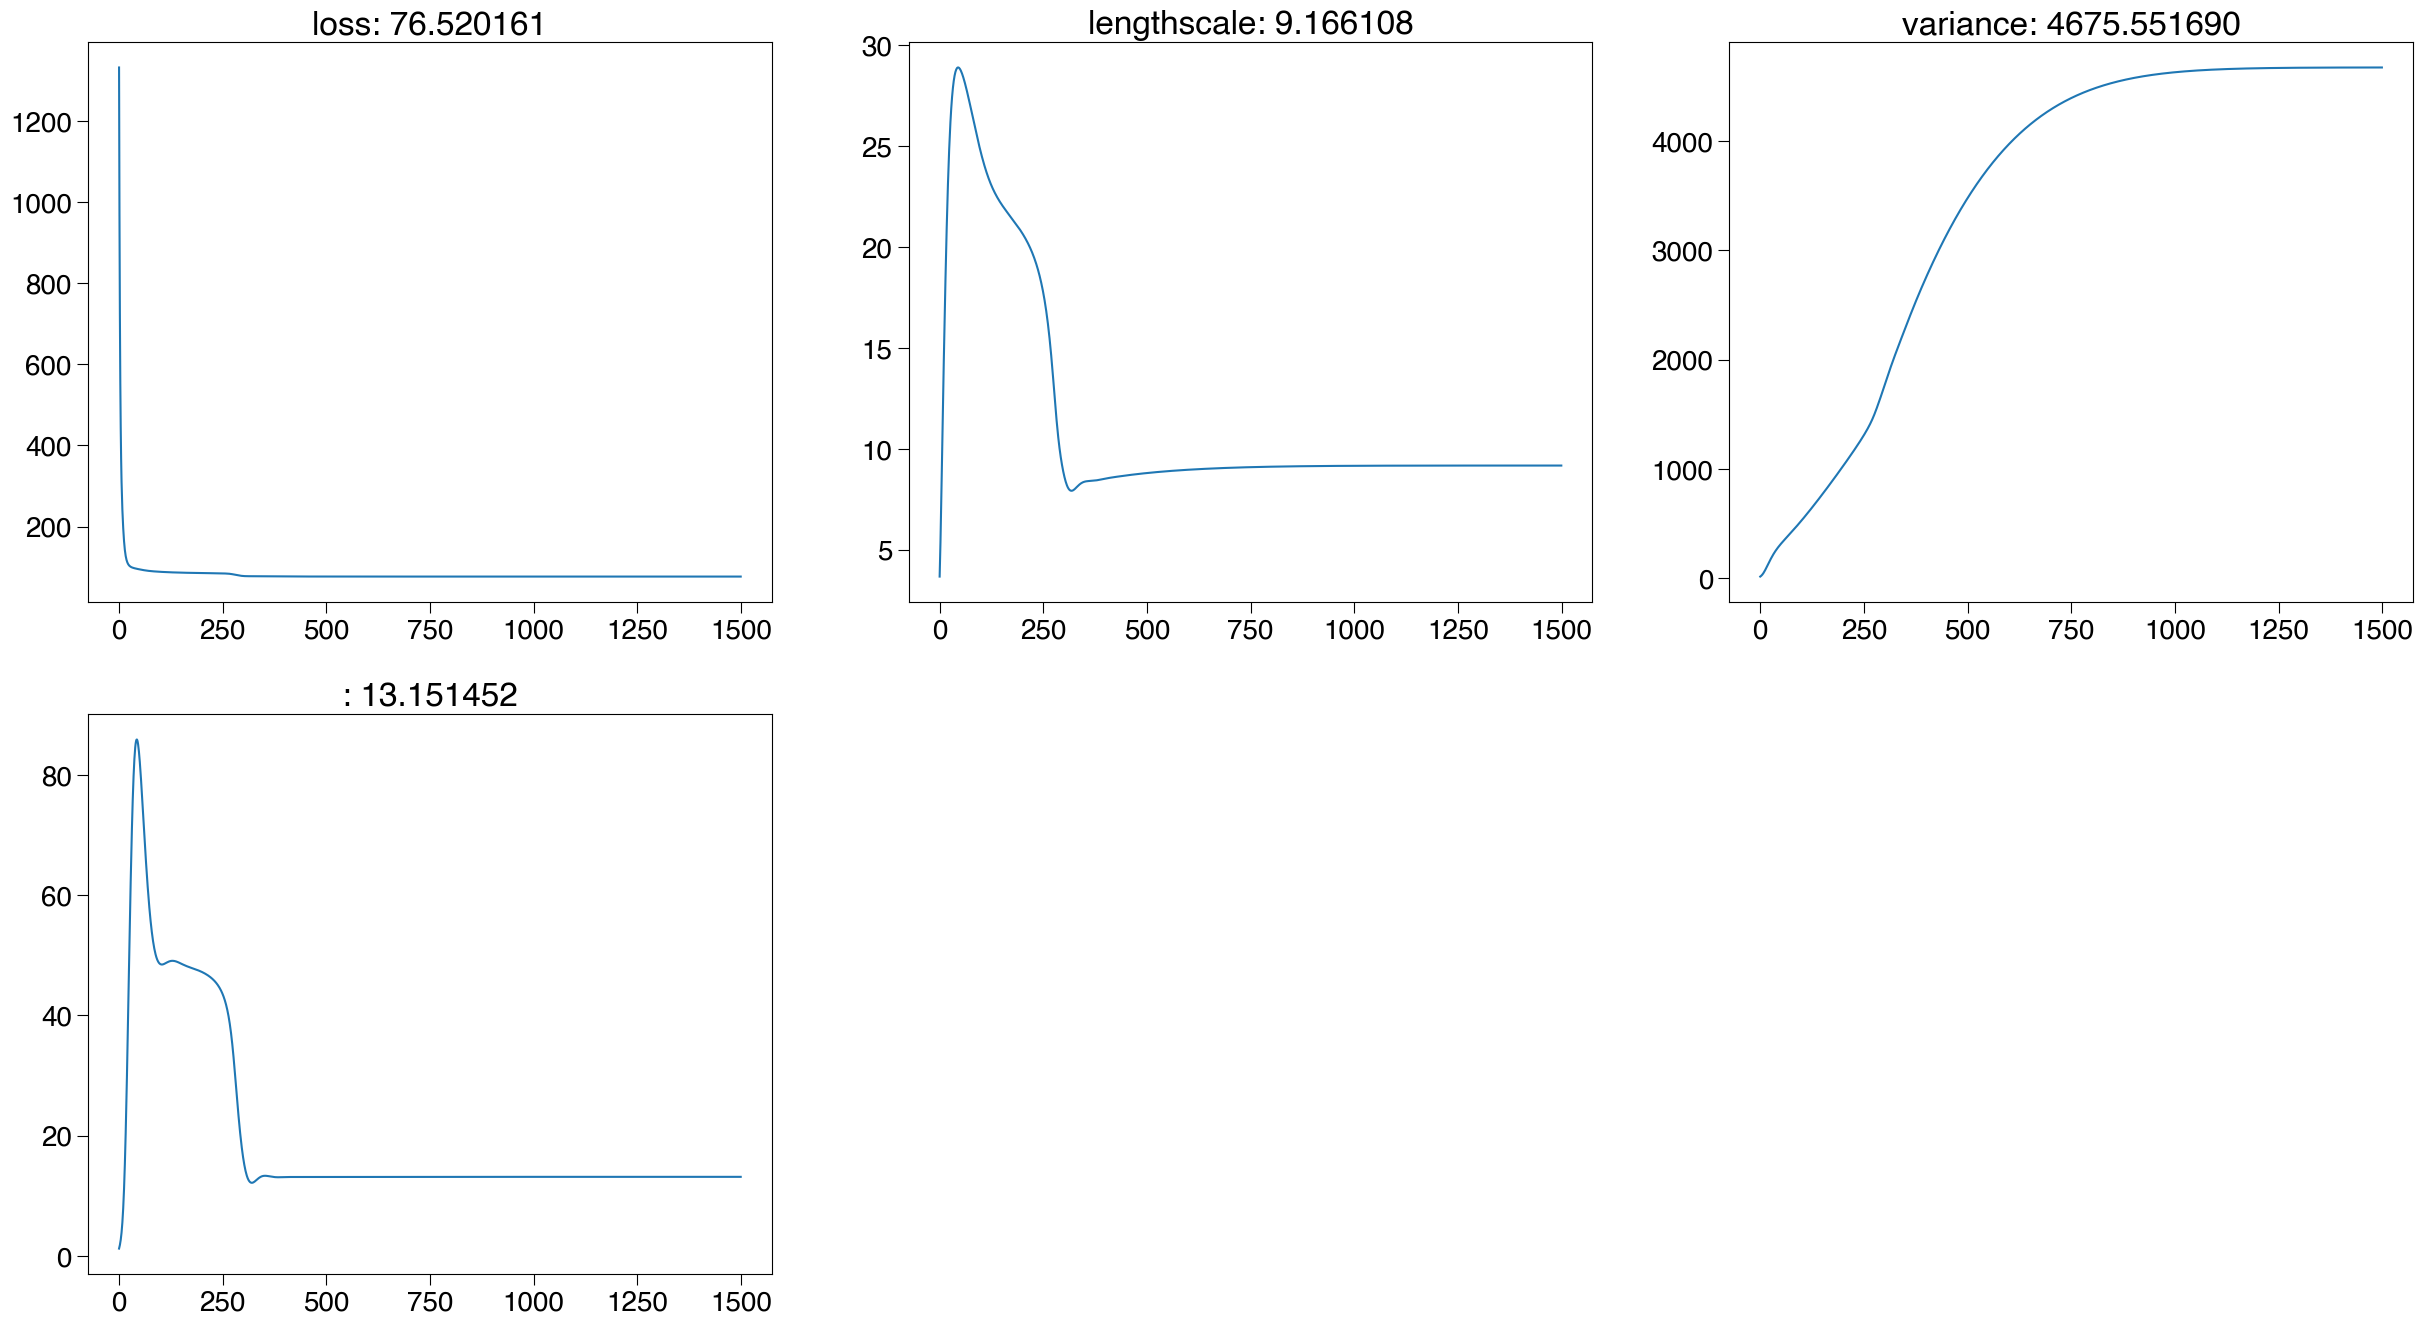

In [57]:
st = time.time() 

#make sure you clear all the parameter store before you define a new model
pyro.clear_param_store()
#define GP regression models
RBF = PSTHM.kernels.RBF(input_dim=1,lengthscale=torch.tensor(3),variance=torch.tensor(10))
#define GP regression models
# noise_variance = torch.ones(len(t))*2**2
gpr = PSTHM.model.GPRegression_V(t, noise_tem, RBF) #noise is the variance of the uncertainty 
#optimize GP model parameters
gpr,track_list = PSTHM.opti.SVI_optm(gpr,lr=0.2,num_iteration=1500)

axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))

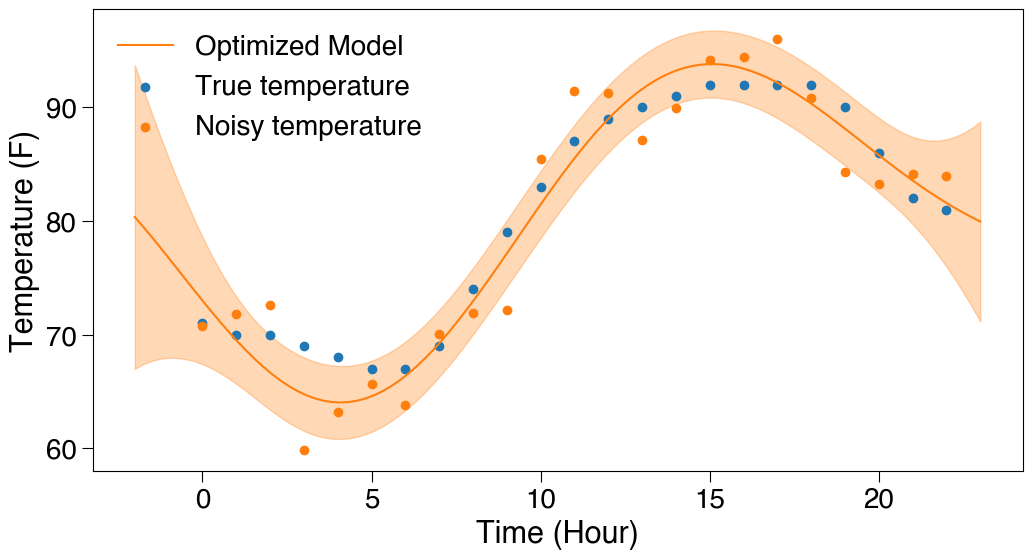

In [58]:
#infer conditional probability distribution for unknown time
time_new = torch.linspace(-2,23,100).double()
mean, cov = gpr(time_new,full_cov=True) 
sd = cov.diag().sqrt()
#-----------------plot-----------------
#in order to plot it with matplotlib, we need to convert torch tensor to numpy array    
plt.figure(figsize=(12,6))

plt.plot(time_new.detach().numpy(),mean.detach().numpy(),label='Optimized Model',color='C1')
plt.fill_between(time_new.detach().numpy(),(mean-2*sd).detach().numpy(),(mean+2*sd).detach().numpy(),alpha=0.3,color='C1')
plt.scatter(t,tem.detach().numpy(),label='True temperature',color = 'C0')
plt.scatter(t,noise_tem.detach().numpy(),label='Noisy temperature',color = 'C1')


plt.legend(loc=0)
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');

We can see that, the optimized model fit well with the noisy data used for training the model, it also did a decent job to fit with true data (green points) which were not provided for model training. This is a major advantage of GP, it can easily deal with noisy that are normally distribued.

You can also draw samples from this optimized model, which can be easily done in pyro: 

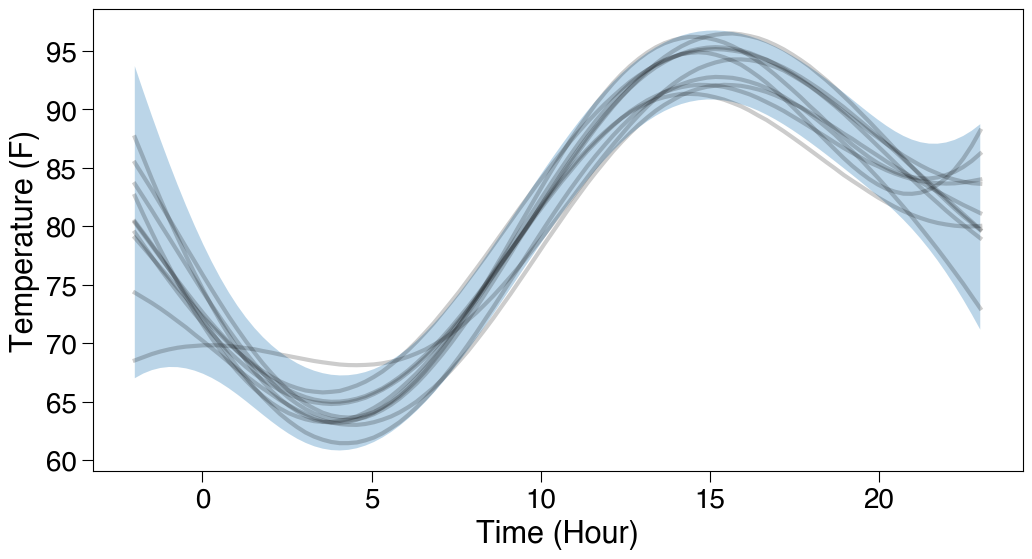

In [66]:
#add a small number to the diagonal of the covariance matrix to make it positive definite
cov += + (torch.ones(len(time_new))*1e-5).diag()
sample_num = 10
samples = dist.MultivariateNormal(
            mean, covariance_matrix=cov
        ).sample(sample_shape=(sample_num,))
plt.fill_between(time_new.detach().numpy(),(mean-2*sd).detach().numpy(),(mean+2*sd).detach().numpy(),alpha=0.3)

for i in range(sample_num):
    plt.plot(time_new.detach().numpy(),(samples[i]).detach().numpy(),lw=3,alpha=0.2,color='k')
plt.xlabel('Time (Hour)')
plt.ylabel('Temperature (F)');


I hope you have some intutions of how GP works now. In this next tutorial, instead of just assuming a RBF kernel, we have lot of kernel options to deal with different problems. See you there.

Thanks for going through this tutorial, we are actively developing PaleoSTeHM now, so your feedback will be truely valueable to us. You can fill this [survey](https://forms.gle/W1DMPQY8KyAgoT9r6) to let us know what do you think about this tutorial, which will shape the future direction of PaleoSTeHM.